In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# --- Settings ---
pd.set_option('display.max_columns', None)
# --- Directories ---
BASE_DIR = os.getcwd()

def build_path(*parts):
    return os.path.join(BASE_DIR, *parts)

FIELD_CONTACT_DIR = os.path.join('..', '..', 'data', 'fieldcontact')
POLICE_REQUESTS_DIR = os.path.join('..', '..', 'data', 'policerequests')
OT_EVENTS_DIR = os.path.join('..', '..', 'data', 'otevents')

# --- Load Data Functions ---
def load_field_contacts():
    files = glob.glob(os.path.join(FIELD_CONTACT_DIR, '*.csv'))
    df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
    return df

def load_police_requests():
    files = glob.glob(os.path.join(POLICE_REQUESTS_DIR, 'Police_Record_Request_*.csv'))
    df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
    return df

def load_ot_events():
    event_files = glob.glob(os.path.join(OT_EVENTS_DIR, '*_otevents.csv'))
    court_files = glob.glob(os.path.join(OT_EVENTS_DIR, '*_courtot.csv'))
    event_df = pd.concat([pd.read_csv(f) for f in event_files], ignore_index=True)
    court_df = pd.concat([pd.read_csv(f) for f in court_files], ignore_index=True)
    return event_df, court_df

# --- 🧹 Preprocessing Functions ---
def preprocess_field_contacts(df):
    df['contact_date'] = pd.to_datetime(df['contact_date'], errors='coerce')
    df['stop_duration'] = df['stop_duration'].fillna(df['stop_duration'].median())
    df['basis'] = df['basis'].fillna('Unknown')
    df['key_situations'] = df['key_situations'].fillna('None')
    df['weather'] = df['weather'].fillna('Unknown')
    return df

def preprocess_ot(df):
    df['OTDATE'] = pd.to_datetime(df['OTDATE'], errors='coerce')
    df['OTHOURS'] = df['OTHOURS'].fillna(0)
    return df

# --- Feature Engineering Functions ---
def feature_engineer_field_contacts(df):
    df['day_of_week'] = df['contact_date'].dt.day_name()
    df['month'] = df['contact_date'].dt.month
    df['year'] = df['contact_date'].dt.year
    
    high_risk_keywords = ['Gun', 'Drugs', 'Gang', 'Shots Fired']
    df['high_risk'] = df['key_situations'].apply(lambda x: any(word in x for word in high_risk_keywords))
    
    return df

def feature_engineer_ot(df):
    df['day_of_week'] = df['OTDATE'].dt.day_name()
    df['month'] = df['OTDATE'].dt.month
    df['year'] = df['OTDATE'].dt.year
    return df

# --- 🚀 Load and Process ---

# Load Data
field_contacts = load_field_contacts()
police_requests = load_police_requests()
otevents, courttot = load_ot_events()

# Preprocess
field_contacts = preprocess_field_contacts(field_contacts)
police_requests = preprocess_ot(police_requests)
otevents = preprocess_ot(otevents)
courttot = preprocess_ot(courttot)

# Feature Engineering
field_contacts = feature_engineer_field_contacts(field_contacts)
notevents = feature_engineer_ot(otevents)
courttot = feature_engineer_ot(courttot)


/var/folders/_r/zj6d9vt949dd8s48h6_3_45m0000gn/T/ipykernel_17810/4164324543.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['OTDATE'] = pd.to_datetime(df['OTDATE'], errors='coerce')
/var/folders/_r/zj6d9vt949dd8s48h6_3_45m0000gn/T/ipykernel_17810/4164324543.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['OTDATE'] = pd.to_datetime(df['OTDATE'], errors='coerce')


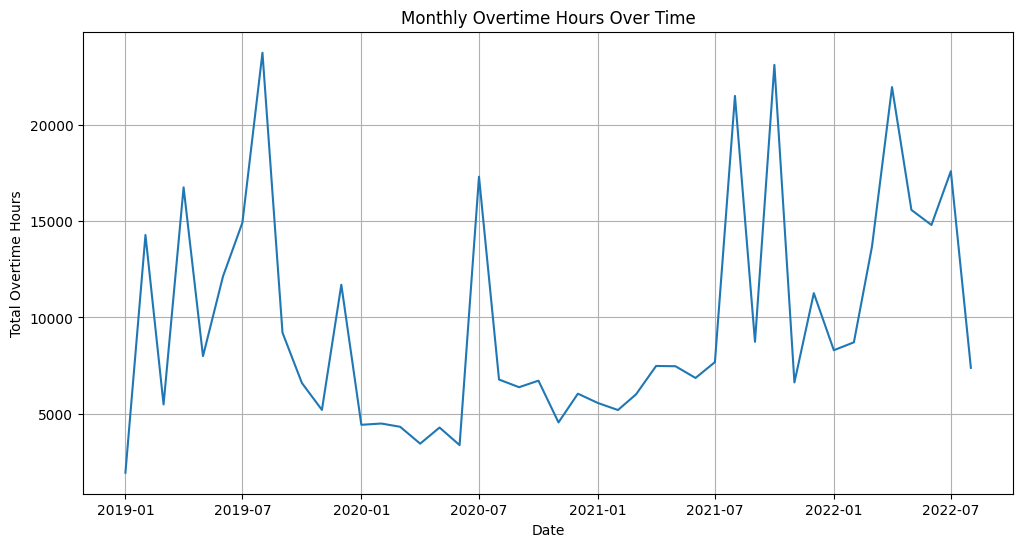

In [3]:
plt.figure(figsize=(12,6))
monthly_ot = otevents.groupby(['year', 'month'])['OTHOURS'].sum().reset_index()
monthly_ot['date'] = pd.to_datetime(dict(year=monthly_ot.year, month=monthly_ot.month, day=1))
monthly_ot = monthly_ot.sort_values('date')

plt.plot(monthly_ot['date'], monthly_ot['OTHOURS'])
plt.title('Monthly Overtime Hours Over Time')
plt.xlabel('Date')
plt.ylabel('Total Overtime Hours')
plt.grid(True)
plt.show()

In [4]:
july_ot = otevents[otevents['month'] == 7]
top_july_events = july_ot['DESCRIPTION'].value_counts().head(15)
print(top_july_events)

DESCRIPTION
INDEPENDENCE DAY       3764
MASS / MELNEA          1941
RED SOX                 820
PUERTO RICAN FEST.      550
NUISANCE PATROL         279
REDSOX                  262
LABOR DISP PO DET        85
D4 COMMUNITY EVENT       72
LNG SECURITY             66
BFS EVENT/ACTIVITY       62
E13 COMMUNITY EVENT      50
B2 COMMUNITY EVENT       47
TD GARDEN EVENTS         45
ROAD RACES               34
LABOR DISP SERGEANT      28
Name: count, dtype: int64


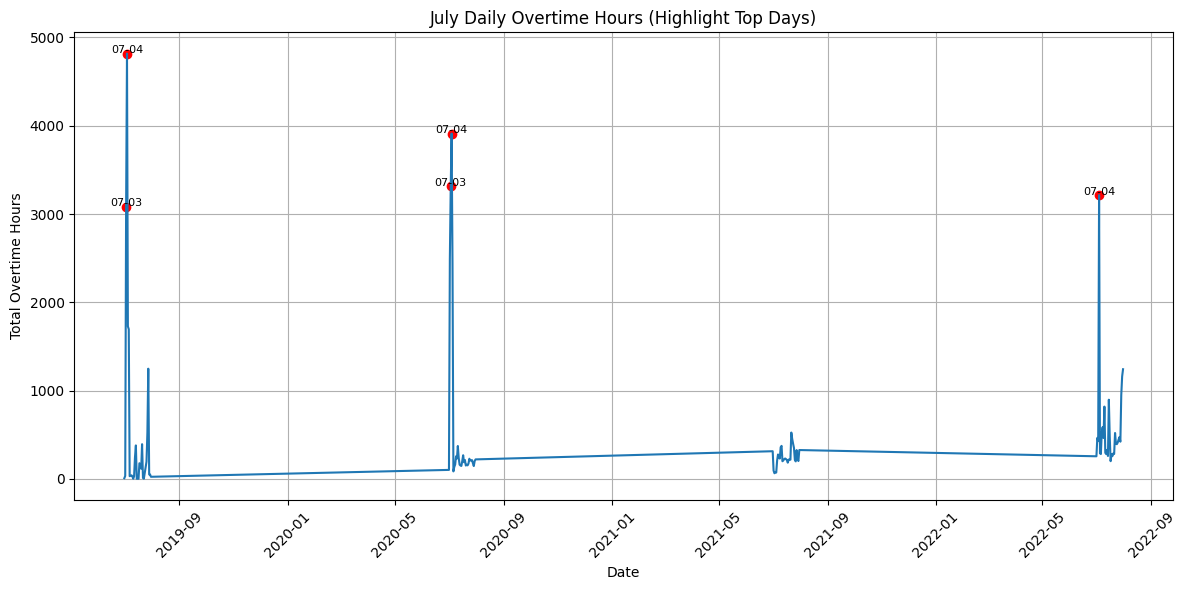

In [5]:
# Group daily overtime in July
july_ot_daily = july_ot.groupby('OTDATE')['OTHOURS'].sum().reset_index()

# Sort and keep only the top 5 heaviest overtime days
top_days = july_ot_daily.sort_values(by='OTHOURS', ascending=False).head(5)

# Plot all days, but highlight top 5
plt.figure(figsize=(12,6))
plt.plot(july_ot_daily['OTDATE'], july_ot_daily['OTHOURS'], label='Daily OT Hours')

# Add markers for top days
plt.scatter(top_days['OTDATE'], top_days['OTHOURS'], color='red')
for idx, row in top_days.iterrows():
    plt.text(row['OTDATE'], row['OTHOURS']+2, row['OTDATE'].strftime('%m-%d'), ha='center', fontsize=8)

plt.title('July Daily Overtime Hours (Highlight Top Days)')
plt.xlabel('Date')
plt.ylabel('Total Overtime Hours')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


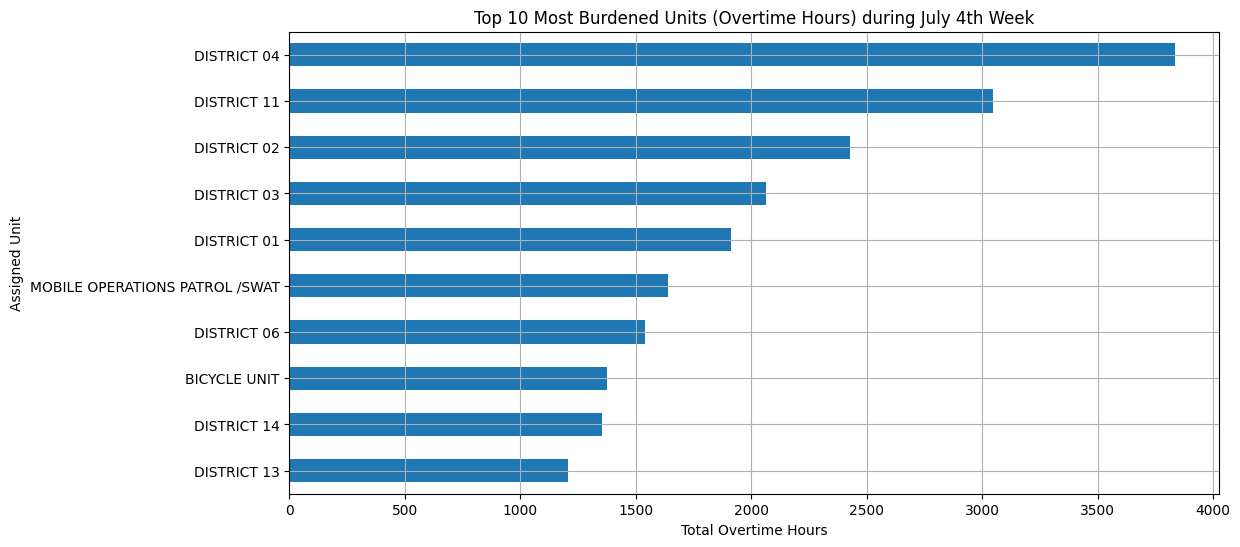

In [ ]:
# First, filter overtime events in July
july_otevents = otevents[otevents['OTDATE'].dt.month == 7]

# Focus around July 4th (+/- a few days)
july4_window = july_otevents[
    (july_otevents['OTDATE'].dt.day >= 1) &
    (july_otevents['OTDATE'].dt.day <= 7)
]

# Group by Assigned Unit
assigned_ot = july4_window.groupby('ASSIGNED_DESC')['OTHOURS'].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
assigned_ot.head(10).plot(kind='barh')  # horizontal bar chart
plt.title('Top 10 Most Burdened Units (Overtime Hours) during July 4th Week')
plt.xlabel('Total Overtime Hours')
plt.ylabel('Assigned Unit')
plt.gca().invert_yaxis()  # so the highest is on top
plt.grid(True)
plt.show()
